# Earth quake
> graph laplacian

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA]

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [5]:
df=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')
df

,Date,Latitude,Longitude,Magnitude
0,01/02/1965,19.2460,145.6160,6.0
1,01/04/1965,1.8630,127.3520,5.8
2,01/05/1965,-20.5790,-173.9720,6.2
3,01/08/1965,-59.0760,-23.5570,5.8
4,01/09/1965,11.9380,126.4270,5.8
...,...,...,...,...
23407,12/28/2016,38.3917,-118.8941,5.6
23408,12/28/2016,38.3777,-118.8957,5.5
23409,12/28/2016,36.9179,140.4262,5.9
23410,12/29/2016,-9.0283,118.6639,6.3


In [6]:
# df.assign 임시 데이터 만들어줘서 원래 데이터 안 건들이게
lst=[df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2017-1965)]

pipe는 튜플로 묶여 있어서 [][] 해줘야 데이터프레임으로 나오지

한 번에 list로 안 되어서 numpy 해준 후 list

`-` 숙제: 

지진자료에서 1985년 이후의 자료만 고른뒤에 HeatMapWithTime()을 이용하여 시각화하라.

In [7]:
lst2=[df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="1985"').\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2016-1985)]

- t = Year
- x = Latitude
- y = Longitude
- f = Magnitude

In [266]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2015"').reset_index().iloc[:,1:]
_df

,Date,Latitude,Longitude,Magnitude,Year
0,01/02/2015,6.5739,60.3653,5.5,2015
1,01/05/2015,-43.0546,171.2364,5.6,2015
2,01/06/2015,55.2049,163.2446,5.6,2015
3,01/07/2015,5.9045,-82.6576,6.5,2015
4,01/08/2015,-61.6118,161.3346,5.7,2015
...,...,...,...,...,...
910,12/28/2016,38.3917,-118.8941,5.6,2016
911,12/28/2016,38.3777,-118.8957,5.5,2016
912,12/28/2016,36.9179,140.4262,5.9,2016
913,12/29/2016,-9.0283,118.6639,6.3,2016


In [267]:
f = _df.loc[:,"Magnitude"].iloc[:-1,]  # 일단 마지막 꺼 수 안맞으니까...일단...

In [268]:
f.shape

(914,)

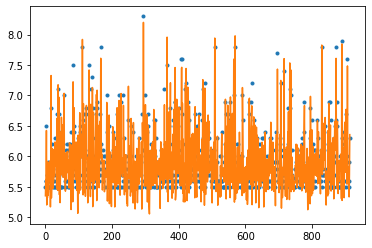

In [269]:
plt.plot(f,'.')
plt.plot(f+np.random.normal(scale=0.2,size=len(f)),'-')

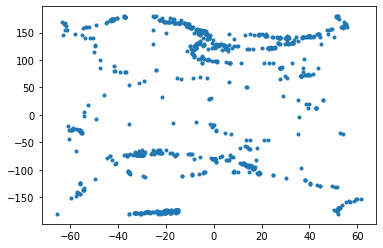

In [270]:
plt.plot( _df.Latitude,_df.Longitude,'.')

$$dist((x_i,y_i),(x_j,y_j))$$

In [271]:
def dist(i,j):
    return np.sqrt( ( ( _df.Latitude[j] - _df.Latitude[i] )**2) + ( ( _df.Longitude[j] - _df.Longitude[i])**2) )

$$W_{i,j}=\begin{cases}{exp(-\frac{[dist(i,j)]^2}{2\theta^2})} & \quad \text{if } dist(i,j) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [272]:
def weight(i,j,theta=10,kappa=100):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

In [273]:
W = np.array([[weight(i,j) for i in range(1,len(_df))] for j in range(1,len(_df))])

In [274]:
W

array([[1.00000000e+00, 7.86860671e-22, 0.00000000e+00, ...,
        1.12413695e-16, 3.04951206e-09, 1.03131967e-16],
       [7.86860671e-22, 1.00000000e+00, 0.00000000e+00, ...,
        1.39055291e-02, 5.30939200e-14, 1.88878509e-02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.12413695e-16, 1.39055291e-02, 0.00000000e+00, ...,
        1.00000000e+00, 2.44062848e-06, 9.94026527e-01],
       [3.04951206e-09, 5.30939200e-14, 0.00000000e+00, ...,
        2.44062848e-06, 1.00000000e+00, 1.57119318e-06],
       [1.03131967e-16, 1.88878509e-02, 0.00000000e+00, ...,
        9.94026527e-01, 1.57119318e-06, 1.00000000e+00]])

In [275]:
D = np.diag(W.sum(axis=1))

In [276]:
D

array([[31.59296441,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 14.54828876,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 37.92968684, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 56.79401824,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        41.43859956,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 55.80133105]])

In [277]:
L = D - W

In [278]:
L

array([[ 3.05929644e+01, -7.86860671e-22,  0.00000000e+00, ...,
        -1.12413695e-16, -3.04951206e-09, -1.03131967e-16],
       [-7.86860671e-22,  1.35482888e+01,  0.00000000e+00, ...,
        -1.39055291e-02, -5.30939200e-14, -1.88878509e-02],
       [ 0.00000000e+00,  0.00000000e+00,  3.69296868e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.12413695e-16, -1.39055291e-02,  0.00000000e+00, ...,
         5.57940182e+01, -2.44062848e-06, -9.94026527e-01],
       [-3.04951206e-09, -5.30939200e-14,  0.00000000e+00, ...,
        -2.44062848e-06,  4.04385996e+01, -1.57119318e-06],
       [-1.03131967e-16, -1.88878509e-02,  0.00000000e+00, ...,
        -9.94026527e-01, -1.57119318e-06,  5.48013310e+01]])

고유값 분해

In [279]:
λ, Ψ = np.linalg.eig(L)

In [280]:
Λ = np.diag(λ)

---

고유값 차이

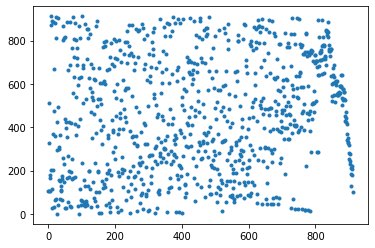

In [281]:
Gap = [np.abs(λ[i] - λ[i-1]) for i in range(1,len(_df)-1)]
plt.plot(np.argsort(Gap),'.')  

In [282]:
import networkx as nx

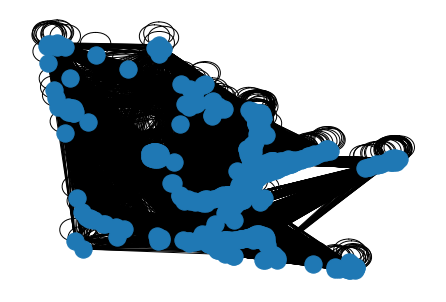

In [283]:
nx.draw(nx.Graph(W))

---

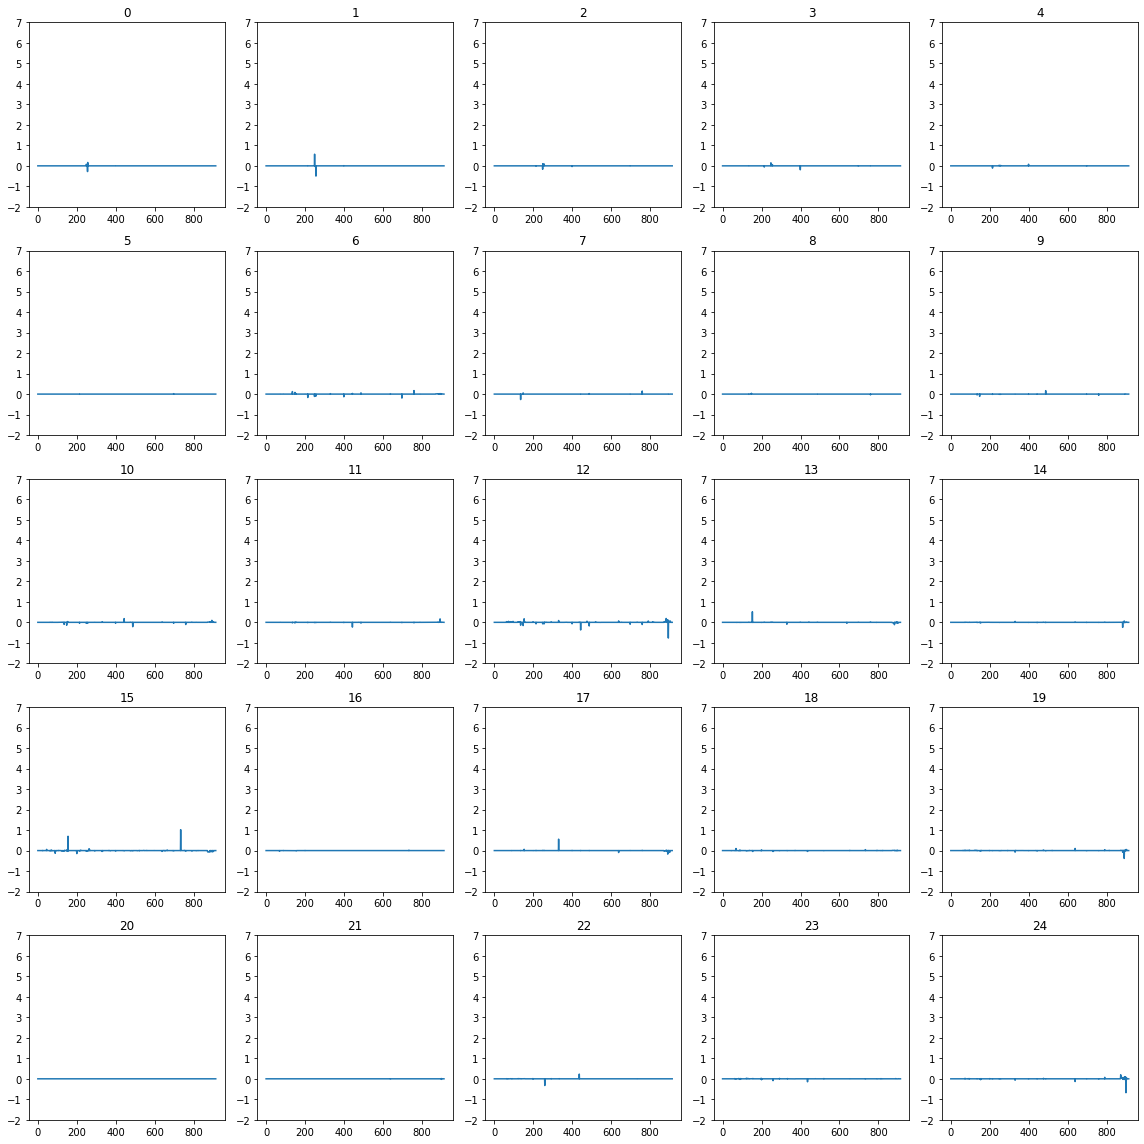

In [284]:
fig,ax =plt.subplots(5,5)
k=0
for i in range(5):
    for j in range(5):
        ax[i][j].plot(f @ np.outer(Ψ[:,k], Ψ[:,k]))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

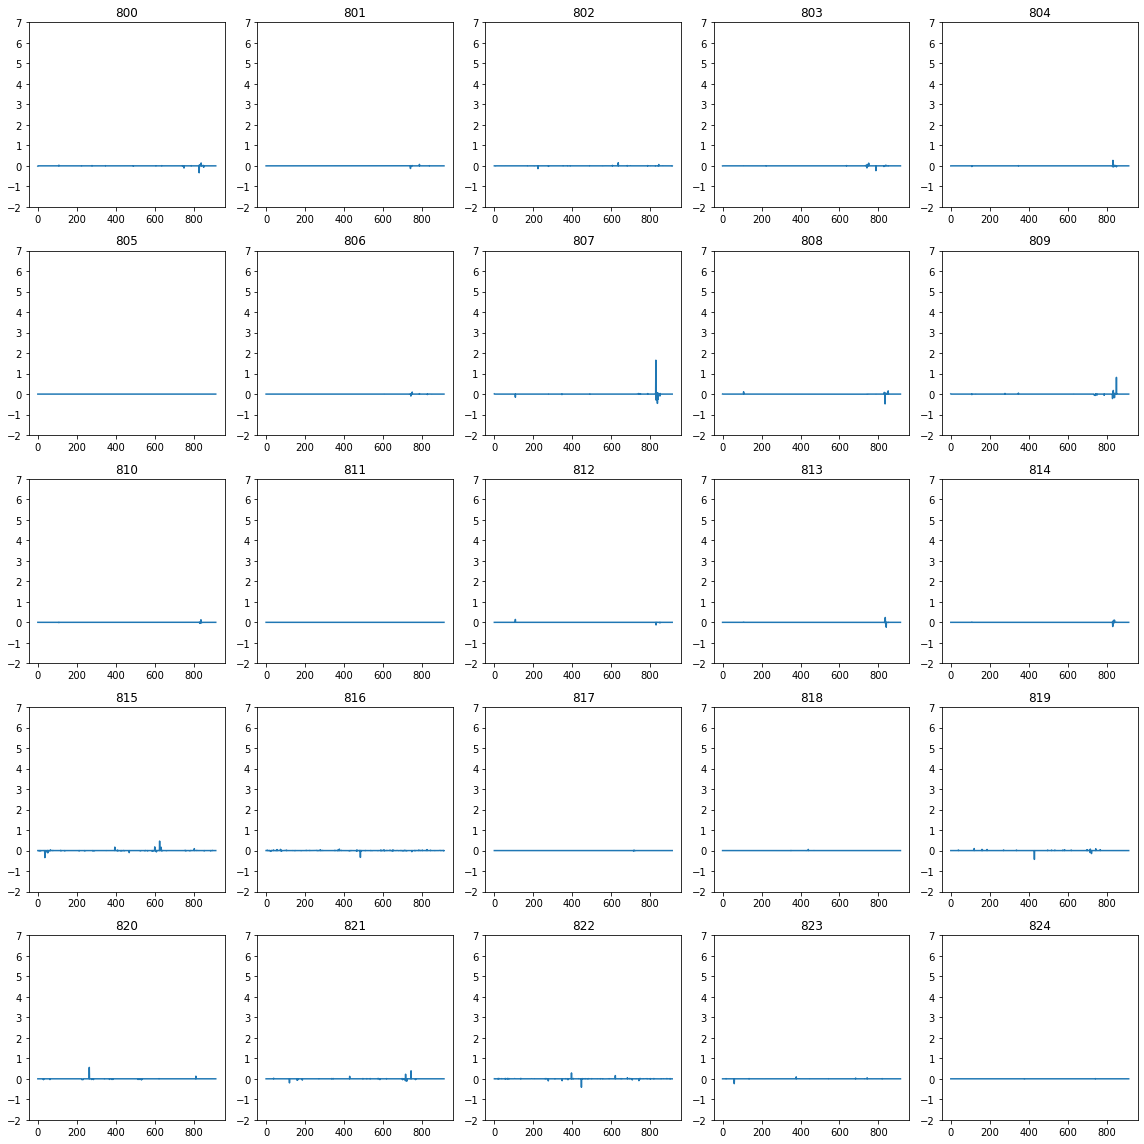

In [297]:
fig,ax =plt.subplots(5,5)
k=800
for i in range(5):
    for j in range(5):
        ax[i][j].plot(f @ np.outer(Ψ[:,k], Ψ[:,k]))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

---